<a href="https://colab.research.google.com/github/TeunKrikke/Colab_playground/blob/master/Matrix_fact_experiment_dereverb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyroomacoustics librosa

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

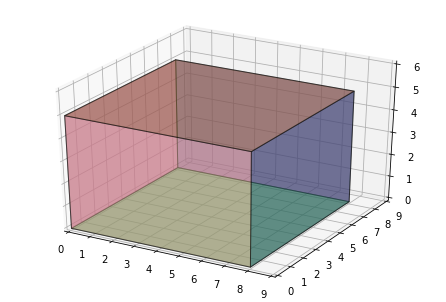

In [0]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T
room = pra.Room.from_corners(corners)
room.extrude(5.)

fig, ax = room.plot()
ax.set_xlim([0, 9])
ax.set_ylim([0, 9])
ax.set_zlim([0, 6]);

In [0]:
from librosa import load, stft, istft
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
speech, sr = load("/content/drive/My Drive/PhD/TIMIT/SA1.WAV")
print(speech.shape)

(67598,)


In [0]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T
room = pra.Room.from_corners(corners)
room.extrude(5.)


room.add_source([8., 4., 1.6], signal=speech)

R = np.array([[4.75, 5.5], [2.0, 2.0], [1.0, 1.0]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

room.simulate()

In [0]:
import IPython

print(room.mic_array.signals.shape)

mic_1 = room.mic_array.signals[0, :speech.shape[0]]
mic_2 = room.mic_array.signals[1, :speech.shape[0]]

(2, 68016)


In [0]:
IPython.display.Audio(mic_1, rate=sr)

In [0]:
nfft = 2048
win = 1024
hop = int(nfft/8)

Y1 = stft(mic_1, n_fft=nfft, hop_length=hop, win_length=win)
Y2 = stft(mic_2, n_fft=nfft, hop_length=hop, win_length=win)
X1 = stft(speech, n_fft=nfft, hop_length=hop, win_length=win)

In [0]:
class beta_NTF(object):
    def __init__(self, W, H, X, A, sigma_b, Q, V, K_partition,
                 epochs=20, debug=False, beta=0):
        super(beta_NTF, self).__init__()

        # np.seterr(all='warn')
        #
        # warnings.filterwarnings('error')
        self._epochs = epochs
        self._debug = debug
        self._V = V
        self._W = W
        self._H = H
        self._A = A
        self._Q = Q
        self._sigma_b = sigma_b
        self._Xb = X
        self._K_partition = K_partition
        self.I, self.F, self.T = X.shape
        self.K = W.shape[1]
        self.J = Q.shape[0]
        self.IJ = self.I*self.J
        self.O = np.ones((1,self.T))
        self.source_ind = []
        for j in range(self.J):
            self.source_ind.append(np.arange(0,self.K/self.J)+(j*(self.K/self.J)))

    def train(self):
        for epoch in range(self._epochs):
            # print(epoch)
            sigma_ss = np.zeros((self.I,self.J,self.F,self.T))
            for i in range(self.I):
                sigma_ss[i,:,:,:] = self._V[:,:,:]
            sigma_ss = sigma_ss.reshape((self.IJ, self.F, self.T))

            sigma_x = np.zeros((self.I,self.I,self.F,self.T), dtype=complex)
            inv_sigma_x = np.zeros((self.I,self.I,self.F,self.T), dtype=complex)

            Gs = np.zeros((self.I,self.IJ,self.F,self.T), dtype=complex)
            s_hat = np.zeros((self.IJ, self.F, self.T), dtype=complex)
            bar_Rxs = np.zeros((self.I, self.IJ, self.F, self.T), dtype=complex)
            bar_Rss_full = np.zeros((self.IJ, self.IJ, self.F, self.T), dtype=complex)
            bar_Rxx = np.zeros((self.I, self.I, self.F, self.T), dtype=complex)
            bar_P = np.zeros((self.J, self.F, self.T))
            bar_A = np.zeros((self.I, self.F, self.K))
            Vc = np.zeros((self.F, self.T, self.K))

            W_prev = self._W
            H_prev = self._H
            A_prev = self._A
            sig_b_prev = self._sigma_b

            sigma_x[0,0,:,:] = np.matmul(self._sigma_b, self.O)
            sigma_x[1,1,:,:] = np.matmul(self._sigma_b, self.O)
            for ij in range(self.IJ):
                sigma_x[0,0,:,:] = sigma_x[0,0,:,:] + np.multiply(np.matmul(np.power(np.abs(self._A[0,ij,:].reshape((self.F, 1))), 2), self.O), sigma_ss[ij,:,:])
                sigma_x[0,1,:,:] = sigma_x[0,1,:,:] + np.multiply(np.matmul(np.multiply(self._A[0,ij,:], np.conj(self._A[1,ij,:])).reshape((self.F, 1)), self.O), sigma_ss[ij,:,:])
                sigma_x[1,0,:,:] = np.conj(sigma_x[0,1,:,:])
                sigma_x[1,1,:,:] = sigma_x[1,1,:,:] + np.multiply(np.matmul(np.power(np.abs(self._A[1,ij,:].reshape((self.F, 1))), 2), self.O), sigma_ss[ij,:,:])

            try:
                det_sigma_x = np.multiply(sigma_x[0, 0, :, :], sigma_x[1,1,:,:]) - np.power(np.abs(sigma_x[0,1,:,:]),2)
                inv_sigma_x [0,0,:,:] = np.divide(sigma_x[1,1,:,:], det_sigma_x)
                inv_sigma_x [0,1,:,:] = np.negative(np.divide(sigma_x[0,1,:,:], det_sigma_x))
                inv_sigma_x [1,0,:,:] = np.conj(inv_sigma_x [0,1,:,:])
                inv_sigma_x [1,1,:,:] = np.divide(sigma_x[0,0,:,:], det_sigma_x)
            except Warning:
                scale = np.sum(self._W, axis=0)
                print(scale)

                # print(self._H)

                print(det_sigma_x)
            #correct till here
            for ij in range(self.IJ):
                Gs[0,ij,:,:] = np.multiply(np.multiply(np.matmul(np.conj(self._A[0,ij,:].reshape((self.F, 1))), self.O), inv_sigma_x [0,0,:,:]) + \
                                           np.multiply(np.matmul(np.conj(self._A[1,ij,:].reshape((self.F, 1))), self.O), inv_sigma_x [1,0,:,:]),
                                           sigma_ss[ij,:,:])
                Gs[1,ij,:,:] = np.multiply(np.multiply(np.matmul(np.conj(self._A[0,ij,:].reshape((self.F, 1))), self.O), inv_sigma_x [0,1,:,:]) + \
                                           np.multiply(np.matmul(np.conj(self._A[1,ij,:].reshape((self.F, 1))), self.O), inv_sigma_x [1,1,:,:]),
                                           sigma_ss[ij,:,:])
                s_hat[ij,:,:] = np.multiply(Gs[0,ij,:,:], self._Xb[0,:,:]) + np.multiply(Gs[1,ij,:,:], self._Xb[1,:,:])
                bar_Rxs[0, ij, :, :] = np.multiply(self._Xb[0,:,:], np.conj(s_hat[ij,:,:]))
                bar_Rxs[1, ij, :, :] = np.multiply(self._Xb[1,:,:], np.conj(s_hat[ij,:,:]))
            # correct till here


            for j1 in range(self.IJ):
                for j2 in range(self.IJ):
                    bar_Rss_full[j1, j2, :, :] = np.multiply(s_hat[j1, :, :], np.conj(s_hat[j2, :, :])) - \
                                                 np.multiply(np.multiply(Gs[0, j1, :, :], np.matmul(self._A[0,j2,:].reshape((self.F, 1)), self.O)) + \
                                                             np.multiply(Gs[1, j1, :, :], np.matmul(self._A[1,j2,:].reshape((self.F, 1)), self.O)),
                                                             sigma_ss[j2,:,:])
                bar_Rss_full[j1,j1,:,:] = bar_Rss_full[j1,j1,:,:] + sigma_ss[j1,:,:]
            # need to check bar_Rss_full calculation very carefully there is a tiny error
            for j in range(self.J):
                start_index = (j*self.I)
                end_index = (j+1) * self.I
                temp_P = np.zeros((self.I, self.F, self.T))
                P_i = 0
                for i in range(start_index, end_index):
                    temp_P[P_i, :, :] = np.real(bar_Rss_full[i,i,:,:])
                    P_i = P_i + 1
                bar_P[j, :, :] = np.mean(temp_P, axis=0)
            # correct till here
            bar_Rxx[0,0,:,:] = np.power(np.abs(self._Xb[0,:,:]),2)
            bar_Rxx[0,1,:,:] = np.multiply(self._Xb[0,:,:], np.conj(self._Xb[1,:,:]))
            bar_Rxx[1,0,:,:] = np.conj(bar_Rxx[0,1,:,:])
            bar_Rxx[1,1,:,:] = np.power(np.abs(self._Xb[1,:,:]),2)
            # outers are correct middle has a small error

            for f in range(self.F):
                self._A[:,:,f] = np.matmul(np.mean(bar_Rxs[:,:,f,:], axis=2),np.linalg.inv(np.mean(bar_Rss_full[:,:,f,:], axis=2)))

            for f in range(self.F):
                self._sigma_b[f] = 0.5 * np.real(np.trace(np.mean(bar_Rxx[:,:,f,:],axis=2) - \
                                   np.matmul(self._A[:,:,f], np.conj(np.transpose(np.mean(bar_Rxs[:,:,f,:],axis=2)))) - \
                                   np.matmul(np.mean(bar_Rxs[:,:,f,:],axis=2), np.conj(np.transpose(self._A[:,:,f]))) + \
                                   np.matmul(np.matmul(self._A[:,:,f], np.mean(bar_Rss_full[:,:,f,:],axis=2)),
                                             np.conj(np.transpose(self._A[:,:,f])))))

            # correct till here
            self.calculate_V()

            VP_neg = np.multiply(np.power(self._V, -2), bar_P)
            V_pos = np.power(self._V, -1)

            WoH = np.zeros((self.F, self.T, self.K))
            for k in range(self.K):
                W_k = self._W[:,k].reshape(-1,1)
                H_k = self._H[k,:].reshape(1,-1)
                WoH[:,:,k] = np.matmul(W_k, H_k)

            Q_num = np.matmul(VP_neg.reshape((self.J, self.F*self.T)), WoH.reshape((self.F*self.T, self.K)))
            Q_den = np.matmul(V_pos.reshape((self.J, self.F*self.T)), WoH.reshape((self.F*self.T, self.K)))
            self._Q = np.multiply(self._Q, np.divide(Q_num, Q_den))

            QoH = self.calculate_V()

            VP_neg = np.multiply(np.power(self._V, -2), bar_P)
            V_pos = np.power(self._V, -1)
            W_num = np.matmul(np.moveaxis(VP_neg, 1, 0).reshape((self.F, self.J*self.T)), QoH.reshape((self.J*self.T, self.K)))
            W_den = np.matmul(np.moveaxis(V_pos, 1, 0).reshape((self.F, self.J*self.T)), QoH.reshape((self.J*self.T, self.K)))
            self._W = np.multiply(self._W, np.divide(W_num, W_den))

            QoW = np.zeros((self.J, self.F, self.K))
            for k in range(self.K):
                Q_k = self._Q[:,k].reshape((-1, 1))
                W_k = self._W[:,k].reshape((1,-1))
                QoW[:,:,k] = np.matmul(Q_k, W_k)

            self.calculate_V()

            VP_neg = np.multiply(np.power(self._V, -2), bar_P)
            V_pos = np.power(self._V, -1)

            H_num = np.matmul(VP_neg.reshape((self.J*self.F,self.T)).transpose(), QoW.reshape((self.J*self.F, self.K)))
            H_den = np.matmul(V_pos.reshape((self.J*self.F,self.T)).transpose(), QoW.reshape((self.J*self.F, self.K)))
            self._H = np.multiply(self._H, np.divide(H_num, H_den).transpose())
            # small error in V and H

            for j in range(self.J):
                nonzero_f_ind = np.nonzero(self._A[0, j, :])
                self._A[1, j, nonzero_f_ind] = np.divide(self._A[1, j, nonzero_f_ind], self.sign(self._A[0,j,nonzero_f_ind]))
                self._A[0, j, nonzero_f_ind] = np.divide(self._A[0, j, nonzero_f_ind], self.sign(self._A[0,j,nonzero_f_ind]))

                A_scale = np.power(np.abs(self._A[0,j,:]),2) + np.power(np.abs(self._A[1,j,:]),2)
                self._A[:, j,:] = np.divide(self._A[:, j,:], np.tile(np.sqrt(A_scale).reshape(1,-1),(self.I,1)))
                self._W[:,self.source_ind[j]] = np.multiply(self._W[:,self.source_ind[j]], np.matmul(A_scale.reshape(-1,1),np.ones((1,len(self.source_ind[j])))))
            #
            # print(self._A[0,0,0])
            # print(self._A[0,1,1])
            # print(self._A[1,0,0])
            # print(self._A[1,1,1])


            scale = np.sum(self._Q, axis=0)
            self._Q = np.multiply(self._Q, np.tile(np.power(scale,-1),(self.J,1)))
            self._W = np.multiply(self._W, np.tile(scale,(self.F,1)))

            scale = np.sum(self._W, axis=0).reshape(1,-1)

            self._W = np.multiply(self._W, np.tile(np.power(scale,-1),(self.F,1)))
            self._H = np.multiply(self._H, np.tile(scale.transpose(),(1,self.T)))
            #
            self.calculate_V()
            # print(self._V[0,0,0])
            # print(self._V[0,1,1])
            # print(self._V[1,0,0])
            # print(self._V[1,1,1])

            criterion = np.sum(np.divide(bar_P, self._V) - np.log(np.divide(bar_P, self._V))) - self.J*self.F*self.T

    def sign(self, x):
        return np.divide(x,np.abs(x))

    def calculate_V(self):
        QoH = np.zeros((self.J, self.T, self.K))
        for k in range(self.K):
            Q_k = self._Q[:,k].reshape((-1, 1))
            H_k = self._H[k,:].reshape((1,-1))
            QoH[:,:,k] = np.matmul(Q_k, H_k)

        self._V = np.zeros((self.J, self.F, self.T))
        for j in range(self.J):
            self._V[j, :, :] = np.matmul(self._W, QoH[j,:,:].reshape((self.T, self.K)).transpose())

        return QoH

    def reconstruct(self):
        Y = np.zeros((self.I,self.J,self.F,self.T), dtype=complex)
        for t in range(self.T):
            for f in range(self.F):
                RV = np.zeros((self.I, self.I))
                for j in range(self.J):
                    start_index = (j*self.I)
                    end_index = (j+1) * self.I
                    RV = RV + (np.matmul(self._A[:,start_index:end_index,f],np.conj(np.transpose(self._A[:,start_index:end_index,f]))) * self._V[j,f,t])
                for j in range(self.J):
                    start_index = (j*self.I)
                    end_index = (j+1) * self.I
                    R = np.matmul(self._A[:,start_index:end_index,f],np.conj(np.transpose(self._A[:,start_index:end_index,f])))
                    Y[:,j,f,t] = np.matmul(np.matmul((R * self._V[j,f,t]), np.linalg.inv(RV)), self._Xb[:,f,t])

        return Y

    def getAV(self):
        return self._A, self._V


In [0]:
I = 2
J = 2
IJ = I * J
F, T = Y1.shape
X = np.asarray([Y1, Y2])
K_partition = np.asarray([20,20])
# K_partition = np.asarray([50,50])
# K_partition = np.asarray([100,100])
# K_partition = np.asarray([150,150])
K = np.sum(K_partition)
print(X.shape)
mix_psd = 0.5 * (np.mean(np.power(np.abs(X[0,:,:]),2) + np.power(np.abs(X[1,:,:]),2),axis=1))
mix_psd = mix_psd.reshape((-1, 1))

A = 0.5 * np.multiply(1.9 * np.abs(np.random.randn(I,IJ,F)) + 0.1 * np.ones((I,IJ,F)),np.sign(np.random.randn(I,IJ,F) + 1j *np.random.randn(I,IJ,F)))
W = 0.5 * np.multiply(np.abs(np.random.randn(F,K)) + np.ones((F,K)), np.matmul(mix_psd, np.ones((1,K))))
H = 0.5 * np.abs(np.random.randn(K,T)) + np.ones((K,T))
Q = 0.5 * np.abs(np.random.randn(J,K)) + np.ones((J,K))
sigma_b = mix_psd / 100

QoH = np.zeros((J, T, K))
for k in range(K):
    Q_k = Q[:,k].reshape((-1, 1))
    H_k = H[k,:].reshape((1,-1))
    QoH[:,:,k] = np.matmul(Q_k, H_k)

V = np.zeros((J, F, T))
for j in range(J):
    V[j, :, :] = np.matmul(W, QoH[j,:,:].reshape((K, T)))

(2, 1025, 265)


In [0]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=1)